# Tutorial 4: Plasticity and Learning

This tutorial consists of two parts:

Part 1. Review Spike-Timing Dependent Plasticity (STDP) and its varieties.

Part 2. Implement unsupervised pattern-detection in continuous spike trains using STDP.

## Part 1: STDP and its varities

STDP alters the weights of synapses depending on the <b>relative</b> spike timing between the postsynaptic neuron and the presynaptic neuron.

<img src="http://www.scholarpedia.org/w/images/6/6a/STDP-Fig1.JPEG" alt="STDP overview (from Jesper Sjöström and Wulfram Gerstner (2010), Scholarpedia, 5(2):1362)" title="STDP overview (from Jesper Sjöström and Wulfram Gerstner (2010), Scholarpedia, 5(2):1362)" />
<i>STDP overview (from [Sjöström J, Gerstner W (2010) Spike-timing dependent plasticity. Scholarpedia](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity))</i>

Within some time windows:
 - if PRE before POST, we get Long-Term Potentiation (LTP)
 - if POST before PRE, we get Long-Term Depression (LTD)
 
The time windows for LTP and LTD are generally on the order of tens of milliseconds, and the LTD window is generally longer than the LTP window.

To implement STDP in spiking neural network models, different STDP rules can be used. In general, different rules result in different distributions of synaptic weights over the course of learning. Examples of such weight distributions are shown below.

<img src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0025339.g010" alt="STDP rules (from Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP: Long-Tail Weight Distributions Solve the Dilemma. PLoS ONE 6(10): e25339)" title="STDP rules (Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP: Long-Tail Weight Distributions Solve the Dilemma. PLoS ONE 6(10): e25339)" />
<i>STDP rules (from [Gilson M, Fukai T (2011) Stability versus Neuronal Specialization for STDP. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0025339))</i>

Additive STDP tends to produce competition between synapses but needs to have its weights bound to ensure network stability (e.g. to avoid over-excitation), whereas multiplicative STDP tends to produce less competition between synapses but owing to its weight-dependent manipulation of synaptic weights does not require artificial bounds. Logorithmic STDP attempts to reconcile the two.

In the following exercise, we will use the additive STDP rule, sometimes also called the exponential STDP rule:

$
\begin{equation}
 \Delta w_j=
 \begin{cases}
   a^+ \cdot e^{\big( \dfrac{t_j-t_i}{\tau^+} \big)} & \text{if}\ t_j \leq t_i & \text{(LTP)} \\
   -a^- \cdot e^{\big( - \dfrac{t_j-t_i}{\tau^-} \big)} & \text{if}\ t_j > t_i & \text{(LTD)}
 \end{cases}
\end{equation}
$

where
 - $a^+$ learning rate for LTP 
 - $a^-$ learning rate for LTD
 - $t_j$ spike time of the presynaptic neuron $j$
 - $t_i$ spike time of the postsynaptic neuron $i$
 - $\tau^+$ time constant for LTP (ms)
 - $\tau^-$ time constant for LTD (ms)

Using pre-defined paramaters which we will use in the second part of this tutorial, let's plot how the this STDP rule changes weights depending on the timing of presynaptic and postsynaptic spikes.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 300.0 # modifying dots per inch for figures

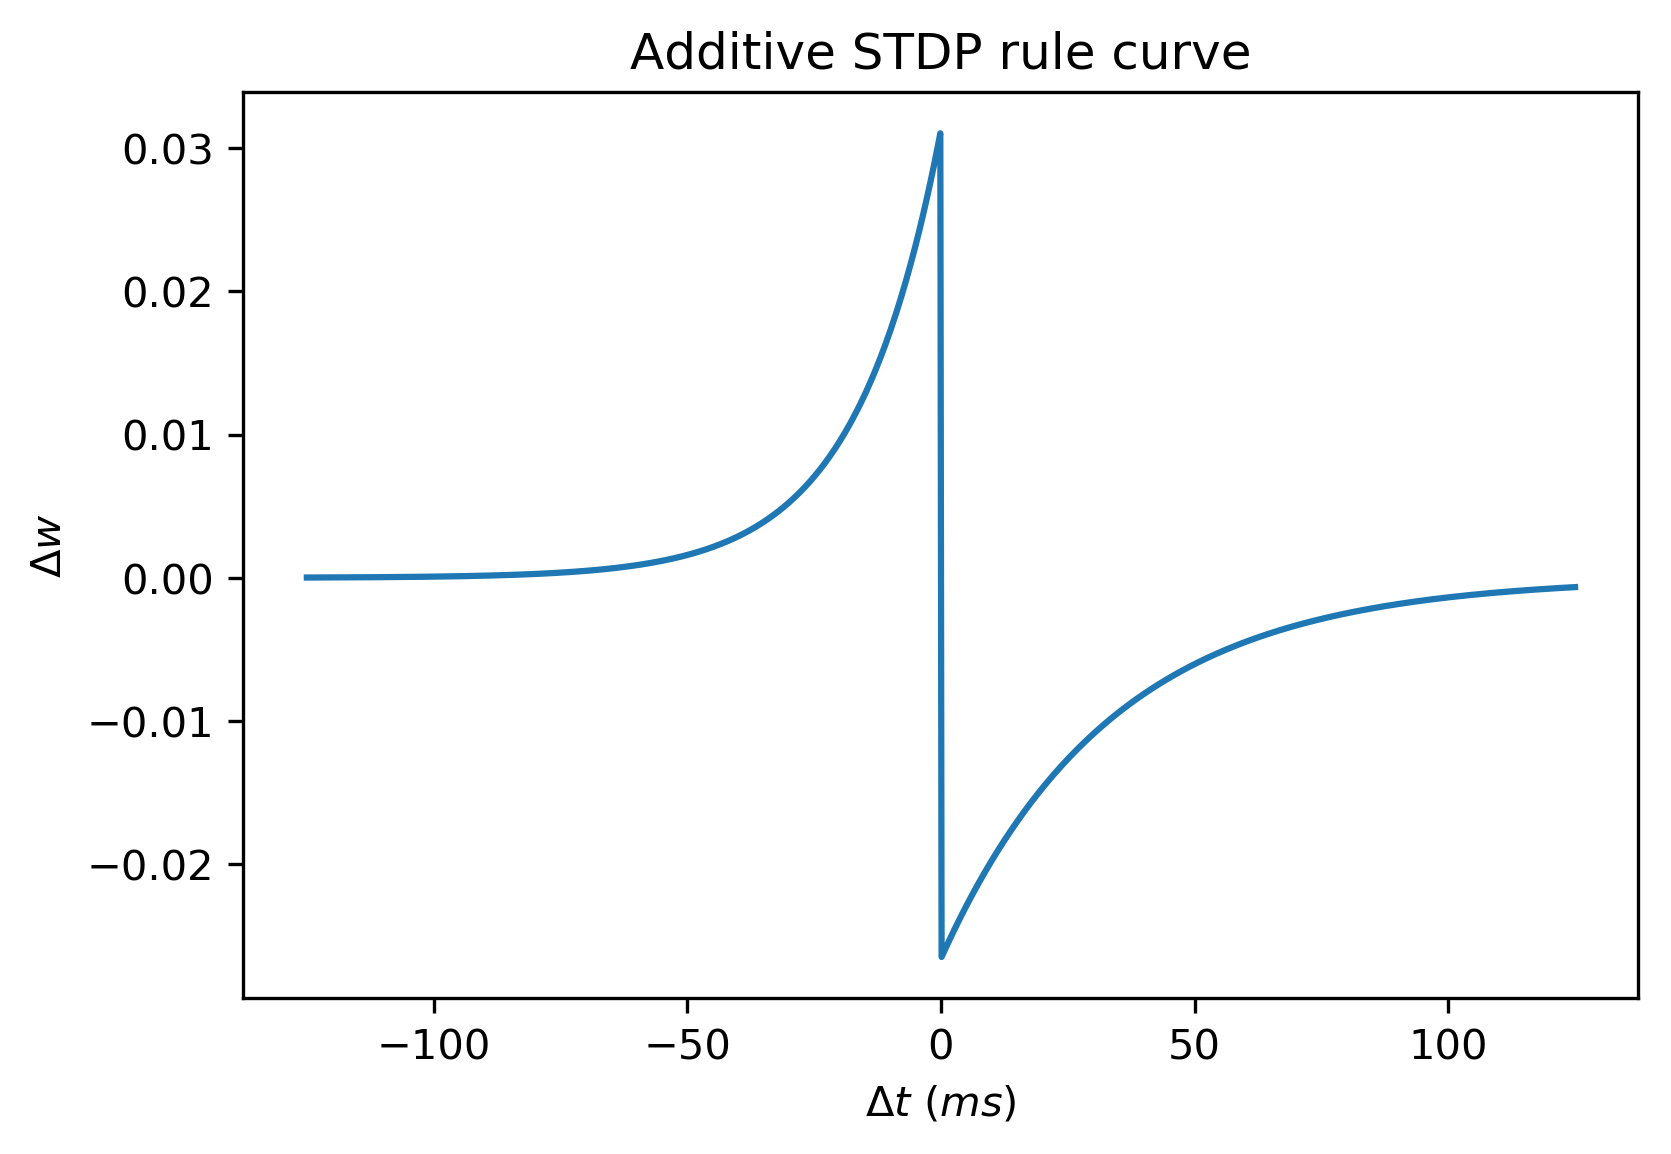

In [3]:
# pre-defined paramaters
add_STDP_paramaters = {
    'a_LTP' : 0.03125,
    'a_LTD' : 0.85 * 0.03125,
    'tau_LTP' : 16.8,
    'tau_LTD' : 33.7
}

# define the additive STDP rule as a function
def add_STDP(time_difference, params=add_STDP_paramaters):
    if time_difference <= 0:
        return params['a_LTP'] * np.exp(time_difference/params['tau_LTP'])
    elif time_difference > 0:
        return -params['a_LTD'] * np.exp(-time_difference/params['tau_LTD'])

# calculating the function different values of spike time differences
time_differences = np.linspace(-125,125,num=1_000)
weight_changes = [add_STDP(time_difference) for time_difference in time_differences]

# plotting
plt.plot(time_differences,weight_changes)
plt.title("Additive STDP rule curve")
plt.xlabel("$\Delta t\ (ms)$")
plt.ylabel("$\Delta w$")
plt.show()

### Exercise 1
- What features do you notice in this STDP curve?
- Experiment with different values in `add_STDP_paramaters`. How do each of the values change the shape of the STDP curve?
- How, in a network of neurons, could this STDP rule lead to over-excitation or network instability?

## Part 2: Unsupervised pattern-detection using STDP

In this part of the tutorial we will be replicating the results from <i>[Masquelier et al. (2008) Spike Timing Dependent Plasticity Finds the Start of Repeating Patterns in Continuous Spike Trains. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0001377)</i>. In fact, we already reproduced Figure 2 from their paper in the first part of this tutorial.

Masquelier et al. (2008) create a spiking neural network with 2,000 presynaptic neurons and just <b>one</b> postsynpatic neuron. They implement additative STDP in this network, which allows the postsynaptic neuron to learn to detect the beginning of repeating patterns of spiking activity arriving from the 2,000 presynaptic neurons. Importantly, the presynaptic neurons also have periods of random, non-patterned activity and have additional noisy spiking activity at all times.

Let's begin by constructing the spike trains of the 2,000 presynaptic neurons. We will run our simulations for 450s, so we will create 450s worth of spike trains for these neurons.

The first step is construct random activity with the following properties:
 - each presynpatic neuron will emit spikes independently, generated by a Poisson process which varies randomly in firing rate $r$ in the range of $[0,90]$ Hz
 - the rate of change in $r$ is modified by $dr$, where $dr$ starts at $0$ and is updated randomly from a uniform distribution over $[-360,360]$ Hz/s every millisecond and clipped to within $[-1800,1800]$ Hz/s
 - we will also manually add some additional spikes to guarantee that in every 50ms time bin, each neuron spikes at least once

In [4]:
num_pres = 2_000
simulation_length = 1_000 #ms

min_r = 0
max_r = 90

min_dr_update = -360
max_dr_update = 360
min_dr = -1800
max_dr = 1800

In [5]:
def poisson_train(duration=simulation_length+1):
    spikes = []
    r = 54
    dr = 0
    for step in range(1, duration):
        if (step > 50) & (np.sum(spikes[step-50:step-1]) == 0):
            rnd_time = np.random.randint(step-50,step-1)
            spikes[rnd_time] = 1
            spikes.append(0)
        else:
            dr += np.random.uniform(min_dr_update, max_dr_update)
            dr = np.clip(dr, -1800, 1800)
            r += dr
            r = np.clip(r, 0, 90)/1000
            spikes.append(np.random.poisson(r))
    return spikes

In [6]:
import time

In [7]:
pre_spikes = np.zeros([num_pres, simulation_length])

In [8]:
tic = time.perf_counter()
for pre in range(0, num_pres):
    pre_spikes[pre] = np.asarray(poisson_train())
toc = time.perf_counter()
print(toc-tic)

32.80943242899957


In [9]:
test = np.zeros(num_pres)
test

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
poisson_train()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [11]:
test = []

In [12]:
tic = time.perf_counter()
for pre in range(0, num_pres):
    test.append(poisson_train())
toc = time.perf_counter()
print(toc-tic)

33.4881853079969


In [13]:
import multiprocessing.dummy as mp 

In [14]:
testing = map(poisson_train, range(0, num_pres))

In [ ]:
testing1 = list(testing)

Now we will:
1. divide the presynaptic spiking activity into segments of 50ms
2. select a random 50ms segment to be considered as the "pattern"
3. copy and paste this pattern across the raster plot in a certain proportion of segments

In [86]:
def select_segment(seg_length=50, spikes=pre_spikes, sim_length=simulation_length):
    num_segments = int(sim_length/seg_length)
    selection = np.random.randint(1,num_segments)
    pattern_spikes = pre_spikes[:,selection*seg_length:selection*seg_length+seg_length]
    return pattern_spikes, selection, num_segments

In [87]:
pattern, selected_segment, num_segments = select_segment()

In [41]:
np.shape(pattern)

(2000, 50)

In [42]:
selected_segment

11

In [43]:
num_segments

20

In [64]:
seg_length = 50

In [44]:
frequency_of_patterns=0.25

In [45]:
proportion_of_neurons=0.5

In [50]:
num_repeats = round(frequency_of_patterns*num_segments)
num_repeats

5

In [51]:
idx_repeats = random.sample(range(num_segments), num_repeats)
idx_repeats

[19, 13, 18, 12, 5]

In [53]:
spikes = pre_spikes

In [65]:
for i in range(0, num_segments-1):
    print("from",i*seg_length,"to",i*seg_length+seg_length)

from 0 to 50
from 50 to 100
from 100 to 150
from 150 to 200
from 200 to 250
from 250 to 300
from 300 to 350
from 350 to 400
from 400 to 450
from 450 to 500
from 500 to 550
from 550 to 600
from 600 to 650
from 650 to 700
from 700 to 750
from 750 to 800
from 800 to 850
from 850 to 900
from 900 to 950
from 950 to 1000


In [66]:
int(num_pres*proportion_of_neurons)

1000

In [74]:
num_segments

20

In [77]:
np.shape(pattern[0:int(num_pres*proportion_of_neurons)])

(1000, 50)

In [79]:
i=19
spikes[:,i*seg_length:i*seg_length+seg_length]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
np.shape(spikes[0:int(num_pres*proportion_of_neurons),i*seg_length:i*seg_length+seg_length])

(1000, 50)

In [88]:
def repeat_segment(pattern, selected_segment, num_segments, spikes=pre_spikes, seg_length=50, num_pres=num_pres,
                   proportion_of_neurons=0.5, frequency_of_patterns=0.25):
    num_repeats = round(frequency_of_patterns*num_segments)
    idx_repeats = random.sample(range(num_segments), num_repeats)
    for i in range(0, num_segments-1):
        spikes[0:int(num_pres*proportion_of_neurons),i*seg_length:i*seg_length+seg_length] = pattern[0:int(num_pres*proportion_of_neurons)]
    return spikes

In [92]:
pre_spikes = repeat_segment(pattern, selected_segment, num_segments, spikes=pre_spikes, 
                            seg_length=50, proportion_of_neurons=0.5, frequency_of_patterns=0.25)

Finally, we add an addition $10$ Hz noise to all neurons at all times.

In [26]:
def extra_poisson_noise(num_pres=num_pres, duration=simulation_length+1, frequency=10):
    spikes = np.zeros([num_pres, simulation_length])
    for neuron in range(1, num_pres):
        spikes[neuron-1] = np.random.poisson(frequency/1000, duration-1)
    return spikes

In [27]:
pre_spikes += extra_poisson_noise()
pre_spikes = np.clip(pre_spikes, 0, 1)

In [94]:
neuron_ids = []
spike_times = []
for neuron in range(0, 2000):
    for spike_time in range(0, 500):
        if pre_spikes[neuron,spike_time] == 1:
            neuron_ids.append(neuron)
            spike_times.append(spike_time)

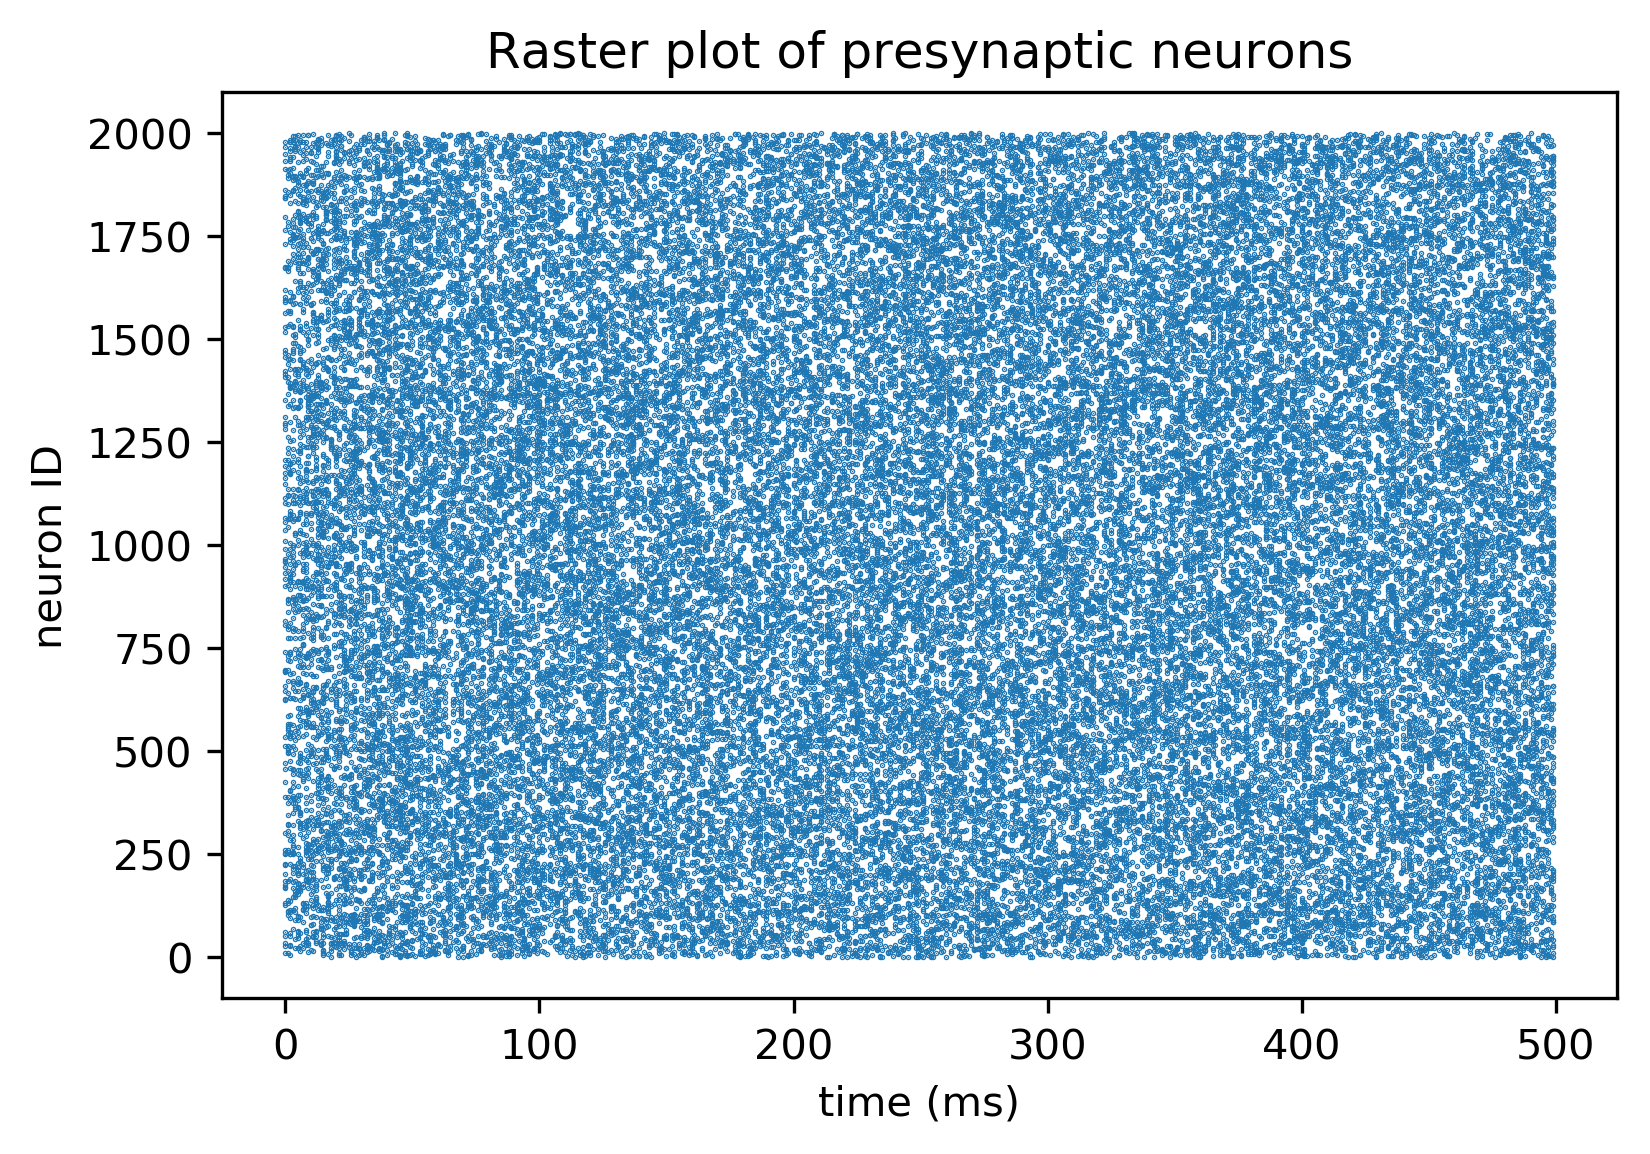

In [95]:
plt.scatter(spike_times,neuron_ids,s=0.1)
plt.title("Raster plot of presynaptic neurons")
plt.xlabel("time (ms)")
plt.ylabel("neuron ID")
plt.show()

In [96]:
firing_rates = []
for neuron in range(0, num_pres):
    firing_rates.append((np.sum(pre_spikes[neuron])/simulation_length)*1_000)

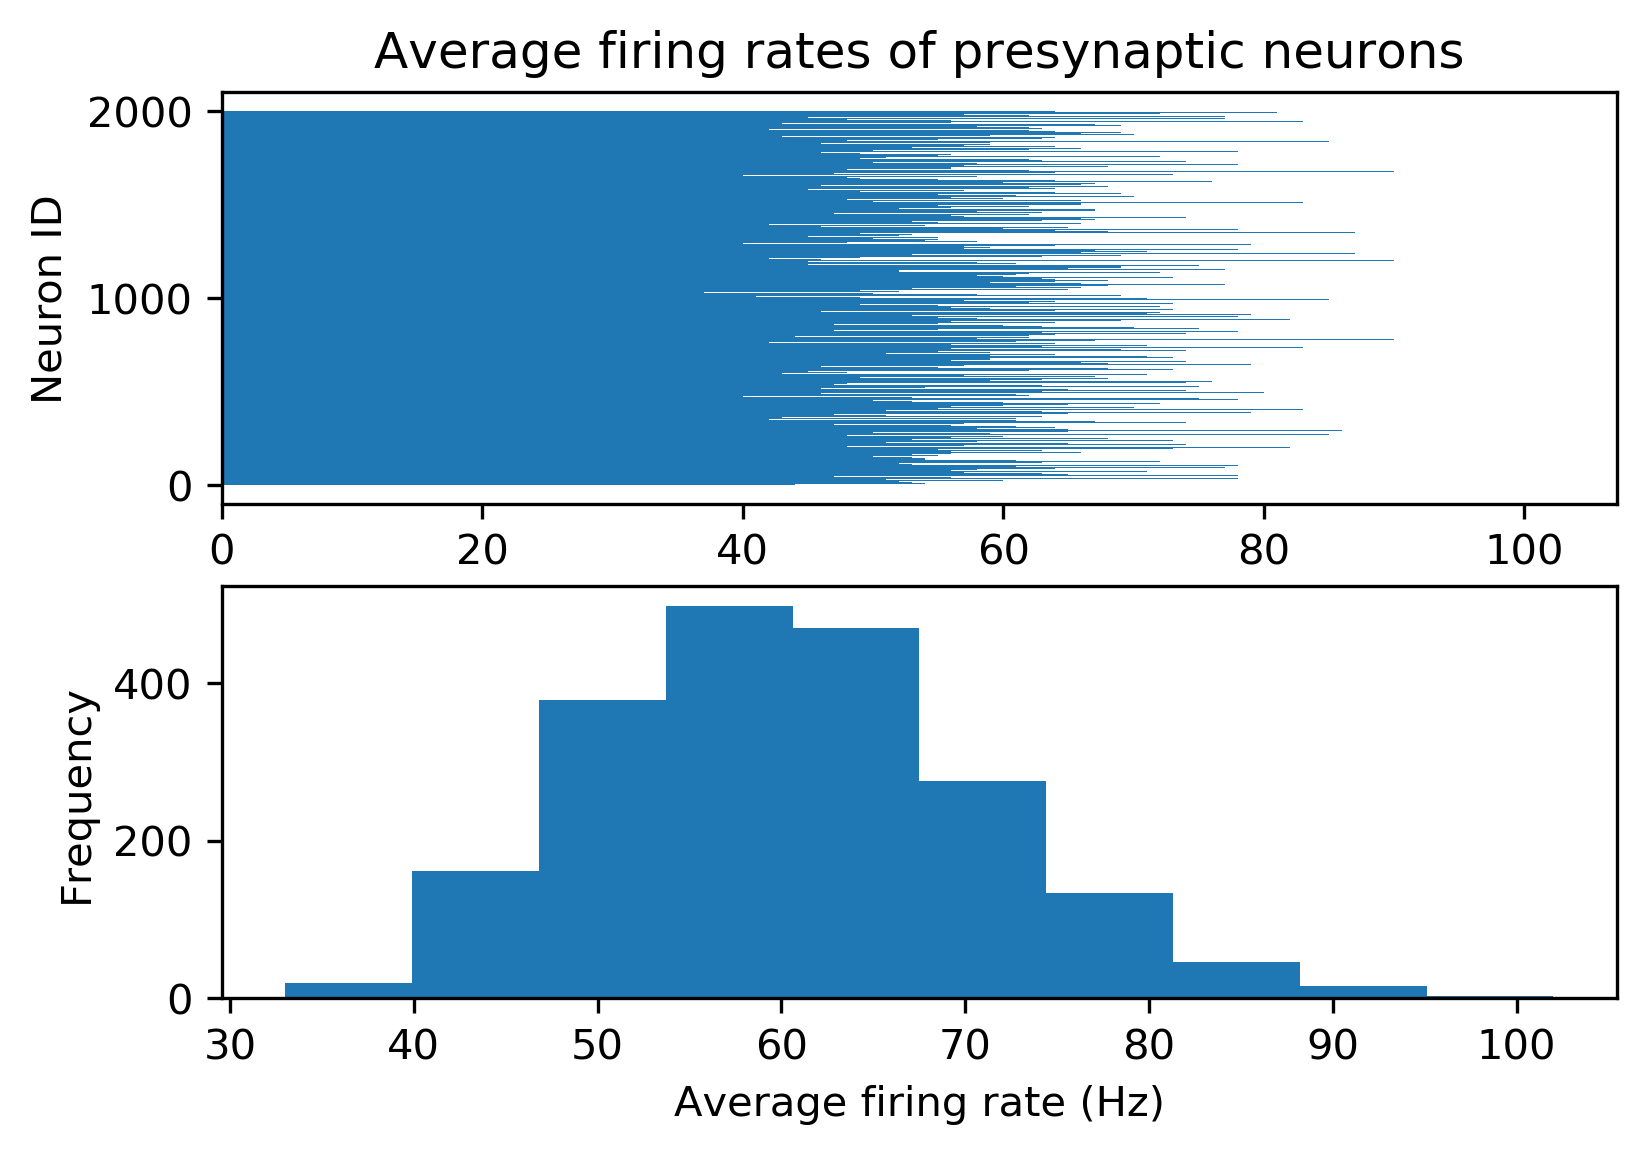

In [97]:
pre_IDs = list(range(0, num_pres))

fig, axes = plt.subplots(2, 1)

axes[0].barh(pre_IDs, firing_rates, height=1)
axes[0].set_title("Average firing rates of presynaptic neurons")
axes[0].set_ylabel("Neuron ID")

axes[1].hist(firing_rates)
axes[1].set_xlabel("Average firing rate (Hz)")
axes[1].set_ylabel("Frequency")

plt.show()

Now we are ready to use these spike trains to train a postsynaptic neuron!

In [17]:
import nest

## Challenge Exercise

Consider whether and how your network could learn multiple patterns, e.g. would you need to add more post-synaptic neurons to the network? Hint: see <i>[Masquelier et al. (2009) Competitive STDP-Based Spike Pattern Learning. Neural Computation](https://www.ncbi.nlm.nih.gov/pubmed/19718815)</i>.